# Логистическая регрессия: классификация “как линейная регрессия, но с вероятностями”

Мы разберём:
- **sigmoid** (как из “линейного ответа” получить вероятность)
- **log loss** (логарифмическая функция потерь / cross‑entropy)
- **confusion matrix**, **precision/recall/F1**
- **ROC‑AUC**
- **порог 0.5 vs другой порог** (как менять поведение модели)

В конце — **10 заданий** для проверки.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    log_loss,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
)

np.set_printoptions(precision=4, suppress=True)
print("Ready!")

Ready!


# 1) Классификация vs регрессия

**Регрессия**: предсказываем число (например, цену дома).  
**Классификация**: предсказываем класс (например, “купит/не купит”).

В бинарной классификации класс обычно:
- `0` — “нет”
- `1` — “да”

Логистическая регрессия устроена так:
1) модель считает линейное выражение:  
   $ z = w_0 + w_1 x_1 + \dots + w_d x_d $
2) превращает его в **вероятность** класса 1 через sigmoid:  
   $ p = \sigma(z) \in (0, 1) $
3) сравнивает с порогом:  
   - если `p >= threshold` → предсказываем `1`
   - иначе → `0`

По умолчанию threshold = **0.5**, но его можно менять (и это важно!).


# 2) Sigmoid (сигмоида)

Сигмоида:
$ \sigma(z) = \frac{1}{1 + e^{-z}} $

Свойства:
- если `z` сильно отрицательный → вероятность близка к 0
- если `z` сильно положительный → вероятность близка к 1
- если `z = 0` → вероятность = 0.5


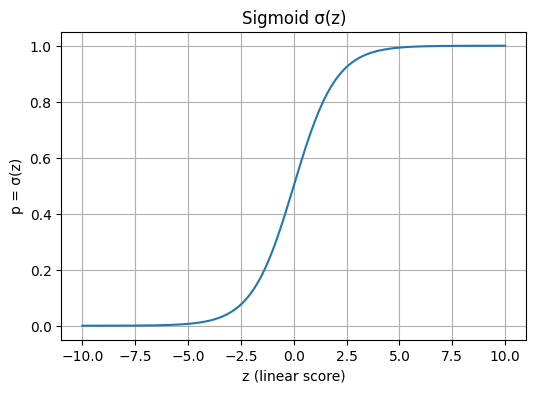

Examples:
z=-5: p=0.0067
z=-2: p=0.1192
z= 0: p=0.5000
z= 2: p=0.8808
z= 5: p=0.9933


In [2]:
def sigmoid(z):
    # z может быть числом или массивом
    return 1 / (1 + np.exp(-z))

z = np.linspace(-10, 10, 200)
p = sigmoid(z)

plt.figure(figsize=(6,4))
plt.plot(z, p)
plt.title("Sigmoid σ(z)")
plt.xlabel("z (linear score)")
plt.ylabel("p = σ(z)")
plt.grid(True)
plt.show()

print("Examples:")
for val in [-5, -2, 0, 2, 5]:
    print(f"z={val:>2}: p={sigmoid(val):.4f}")

# 3) Log loss (binary cross‑entropy)

Log loss:
$
L(y, p) = -\left(y \cdot \log(p) + (1-y)\cdot \log(1-p)\right)
$

Интуиция:
- `y=1` → хотим `p → 1`
- `y=0` → хотим `p → 0`

⚠️ Нельзя `log(0)`, поэтому делаем `clip`.


In [3]:
def log_loss_manual(y_true, p_pred, eps=1e-15):
    p = np.clip(p_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))

y_true = np.array([1, 1, 0, 0, 1])
p_good = np.array([0.9, 0.8, 0.2, 0.1, 0.7])
p_bad  = np.array([0.1, 0.2, 0.8, 0.9, 0.3])

print("Manual log loss (good):", log_loss_manual(y_true, p_good))
print("sklearn log loss (good):", log_loss(y_true, p_good))

print("Manual log loss (bad):", log_loss_manual(y_true, p_bad))
print("sklearn log loss (bad):", log_loss(y_true, p_bad))

Manual log loss (good): 0.20273661557656092
sklearn log loss (good): 0.20273661557656092
Manual log loss (bad): 1.8056037630364457
sklearn log loss (bad): 1.8056037630364457


# 4) Датасет (синтетический) + DataFrame

В реальном проекте вместо этого будет ваш CSV/Kaggle датасет.


In [4]:
X, y = make_classification(
    n_samples=1200, # Сколько объектов (строк) сгенерировать
    n_features=6, # Сколько признаков (столбцов) будет у каждого объекта
    n_informative=4, # Сколько признаков реально несут информацию о классе (target)
    n_redundant=1,
    n_clusters_per_class=2, # Сколько кластеров будет внутри КАЖДОГО класса
    class_sep=1.2, # Насколько далеко разнесены классы (разделимость)
    flip_y=0.03, # Доля “шумных” меток
    random_state=42 # Фиксируем генератор случайных чисел
)

df = pd.DataFrame(X, columns=[f"f{i}" for i in range(X.shape[1])])
df["target"] = y
df.head()

,f0,f1,f2,f3,f4,f5,target
0,1.284795,1.097990,-0.141990,1.611368,-1.851779,1.998861,1
1,1.559938,-1.902022,-2.013736,-1.912366,1.792794,-0.672072,1
2,0.380259,0.477720,1.227394,1.714255,0.386134,0.525751,1
3,0.116562,-0.942467,-0.357668,-1.273542,1.034975,-1.221280,1
4,0.255626,0.439967,0.667294,2.266564,-2.157585,1.130315,1


# 5) Мини‑EDA

Баланс классов + describe + пару scatter.


Shape: (1200, 7)

Class balance:
target
1    0.500833
0    0.499167
Name: proportion, dtype: float64


,f0,f1,f2,f3,f4,f5,target
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.045391,-0.540084,-0.833672,-0.560469,-0.030579,-0.016292,0.500833
std,1.012950,1.609351,2.235848,1.482870,1.855167,1.572463,0.500208
min,-3.296253,-5.366140,-10.649679,-4.828933,-5.773613,-4.563736,0.000000
25%,-0.639396,-1.704903,-1.865351,-1.647031,-1.338145,-1.275371,0.000000
50%,0.045704,-0.769304,-0.700147,-0.688402,-0.053560,-0.081309,1.000000
75%,0.730545,0.565199,0.572648,0.600293,1.341134,1.201719,1.000000
max,4.052550,4.898676,6.976912,3.405048,5.311523,5.359230,1.000000


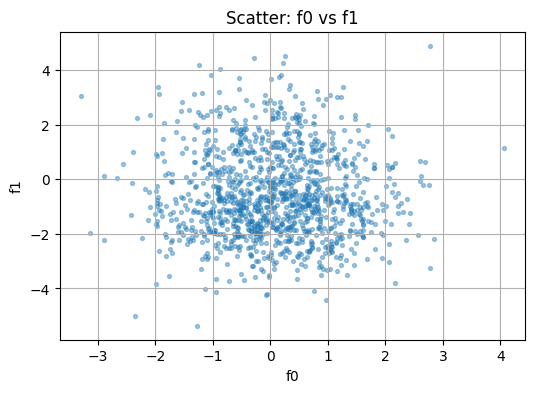

In [5]:
print("Shape:", df.shape)
print("\nClass balance:")
print(df["target"].value_counts(normalize=True))

display(df.describe())

plt.figure(figsize=(6,4))
plt.scatter(df["f0"], df["f1"], s=8, alpha=0.4)
plt.title("Scatter: f0 vs f1")
plt.xlabel("f0")
plt.ylabel("f1")
plt.grid(True)
plt.show()

# 6) Train/Test split + Pipeline preprocessing

Pipeline защищает от утечек и удобен для сохранения модели.


In [15]:
TARGET_COL = "target"
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (900, 6) Test: (300, 6)


In [8]:
num_features = X_train.columns.tolist()

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_features),
])

model = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=2000)),
])

model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2', 'f3', 'f4',
                                                   'f5'])])),
                ('clf', LogisticRegression(max_iter=2000))])

# 7) Обучение + вероятности

- `predict_proba` даёт вероятности
- `predict` даёт классы по порогу 0.5


In [9]:
model.fit(X_train, y_train)

proba_test = model.predict_proba(X_test)[:, 1]
pred_test_default = model.predict(X_test)

print("proba_test[:10] =", np.round(proba_test[:10], 4))
print("pred_test_default[:10] =", pred_test_default[:10])

proba_test[:10] = [0.8088 0.8122 0.9    0.4588 0.3482 0.429  0.2002 0.5302 0.0576 0.9457]
pred_test_default[:10] = [1 1 1 0 0 0 0 1 0 1]


# 8) Метрики + confusion matrix

Считаем:
- log loss (по вероятностям)
- precision/recall/F1 (по классам)


In [10]:
def metrics_at_threshold(y_true, p1, thr=0.5):
    y_pred = (p1 >= thr).astype(int)
    return {
        "threshold": thr,
        "logloss": log_loss(y_true, p1),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }, y_pred

m05, y_pred_05 = metrics_at_threshold(y_test.values, proba_test, thr=0.5)
print(m05)

cm = confusion_matrix(y_test, y_pred_05)
print("\nConfusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred_05, digits=4))

{'threshold': 0.5, 'logloss': 0.5877643725785687, 'precision': 0.7730496453900709, 'recall': 0.7266666666666667, 'f1': 0.7491408934707904}

Confusion matrix:
 [[118  32]
 [ 41 109]]

Classification report:
               precision    recall  f1-score   support

           0     0.7421    0.7867    0.7638       150
           1     0.7730    0.7267    0.7491       150

    accuracy                         0.7567       300
   macro avg     0.7576    0.7567    0.7564       300
weighted avg     0.7576    0.7567    0.7564       300



# 9) Порог 0.5 vs другие пороги

Порог — инструмент управления компромиссом:
- меньше порог → выше recall (обычно), но precision может упасть
- выше порог → выше precision (обычно), но recall может упасть


In [11]:
thresholds = [0.2, 0.35, 0.5, 0.65, 0.8]
rows = []
for t in thresholds:
    m, _ = metrics_at_threshold(y_test.values, proba_test, thr=t)
    rows.append(m)

pd.DataFrame(rows)

,threshold,logloss,precision,recall,f1
0,0.20,0.587764,0.519531,0.886667,0.655172
1,0.35,0.587764,0.609137,0.800000,0.691643
2,0.50,0.587764,0.773050,0.726667,0.749141
3,0.65,0.587764,0.851852,0.613333,0.713178
4,0.80,0.587764,0.870968,0.360000,0.509434


## Подбор порога по F1

В реальном проекте подбираем порог на validation/CV.


In [16]:
grid = np.linspace(0.05, 0.95, 91)
best = None
for t in grid:
    m, _ = metrics_at_threshold(y_test.values, proba_test, thr=float(t))
    if best is None or m["f1"] > best["f1"]:
        best = m
best

{'threshold': 0.48999999999999994,
 'logloss': 0.5877643725785687,
 'precision': 0.7692307692307693,
 'recall': 0.7333333333333333,
 'f1': 0.7508532423208191}

# 10) ROC‑AUC

ROC‑AUC оценивает модель по всем порогам сразу.


ROC-AUC: 0.7700888888888888


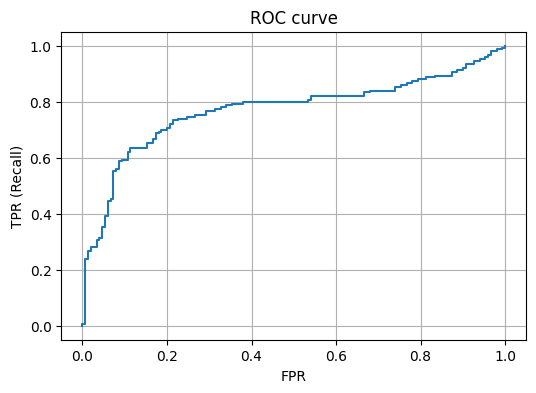

In [13]:
auc = roc_auc_score(y_test, proba_test)
print("ROC-AUC:", auc)

fpr, tpr, thr = roc_curve(y_test, proba_test)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.grid(True)
plt.show()

---
# 10 заданий

Формат: **Задание → подсказка → код с пропусками**.


## Задание 1

**Задание:** Допишите sigmoid и проверьте на z=[-2,0,2].

**Подсказка:** σ(z)=1/(1+exp(-z))


In [ ]:
import numpy as np

def sigmoid_student(z):
    return 1 / (1 + np.exp(_____))

z = np.array(_____)
print(np.round(sigmoid_student(z), 4))

## Задание 2

**Задание:** Допишите manual log loss и сравните со sklearn.log_loss.

**Подсказка:** clip вероятности: np.clip(p, eps, 1-eps)


In [ ]:
import numpy as np
from sklearn.metrics import log_loss

def logloss_student(y_true, p_pred, eps=1e-15):
    p = np.clip(p_pred, _____, _____)
    return -np.mean(y_true * np.log(_____) + (1 - y_true) * np.log(_____))

y_true = np.array([1, 0, 1, 0, 1])
p_pred = np.array([0.9, 0.2, 0.7, 0.1, 0.6])

print("student:", logloss_student(y_true, p_pred))
print("sklearn :", log_loss(y_true, p_pred))

## Задание 3

**Задание:** Сделайте train/test split с stratify=y и test_size=0.2. Выведите доли классов.

**Подсказка:** train_test_split(..., stratify=y)


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[_____])
y = df[_____]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=_____,
    random_state=42,
    stratify=_____
)

print("train share:", y_train.value_counts(normalize=True).to_dict())
print("test  share:", y_test.value_counts(normalize=True).to_dict())

## Задание 4

**Задание:** Соберите Pipeline: imputer(median)+scaler+LogisticRegression(max_iter=2000) и обучите.

**Подсказка:** Pipeline + ColumnTransformer


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

num_features = X_train.columns.tolist()

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy=_____)),
    ("scaler", StandardScaler()),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, _____),
])

pipe = Pipeline([
    ("preprocess", _____),
    ("clf", LogisticRegression(max_iter=_____)),
])

pipe.fit(_____, _____)
print("fit ok")

## Задание 5

**Задание:** Получите proba класса 1 на test и предсказания по умолчанию. Выведите первые 8.

**Подсказка:** predict_proba(... )[:,1] и predict(...)


In [ ]:
proba = pipe._____(X_test)[:, _____]
pred_default = pipe._____(X_test)

print("proba[:8] =", np.round(proba[_____], 4))
print("pred [:8] =", pred_default[_____])

## Задание 6

**Задание:** Посчитайте confusion matrix и precision/recall/F1 для порога 0.5.

**Подсказка:** y_pred = (proba >= 0.5).astype(int)


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

thr = _____
y_pred = (proba _____ _____).astype(int)

cm = confusion_matrix(_____, _____)
prec = precision_score(_____, _____, zero_division=0)
rec  = recall_score(_____, _____, zero_division=0)
f1   = f1_score(_____, _____, zero_division=0)

print(cm)
print("precision:", prec, "recall:", rec, "f1:", f1)

## Задание 7

**Задание:** Сравните метрики для порогов 0.3 и 0.7 и сведите в DataFrame.

**Подсказка:** цикл по thresholds и rows.append({...})


In [ ]:
thresholds = [_____, _____]
rows = []
for t in thresholds:
    y_pred = (proba >= t).astype(int)
    rows.append({
        "threshold": _____,
        "precision": precision_score(y_test, _____, zero_division=0),
        "recall": recall_score(_____, y_pred, zero_division=0),
        "f1": f1_score(y_test, _____, zero_division=0),
    })
pd.DataFrame(_____)

## Задание 8

**Задание:** Найдите порог (0.05..0.95 шаг 0.01), максимизирующий F1.

**Подсказка:** grid = np.linspace(0.05,0.95,91)


In [ ]:
grid = np.linspace(_____, _____, _____)
best_thr, best_f1 = None, -1
for t in grid:
    y_pred = (proba >= t).astype(int)
    f1 = f1_score(_____, y_pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = _____
        best_thr = t

print("best_thr:", _____, "best_f1:", _____)

## Задание 9

**Задание:** Посчитайте ROC-AUC и нарисуйте ROC curve.

**Подсказка:** roc_auc_score и roc_curve


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

auc = roc_auc_score(_____, _____)
print("ROC-AUC:", _____)

fpr, tpr, thr = roc_curve(_____, _____)

plt.figure(figsize=(6,4))
plt.plot(_____, _____)
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.show()

## Задание 10

**Задание:** Сделайте отчёт: log loss + метрики для threshold=0.5 и threshold=best_thr.

**Подсказка:** log_loss(y_test, proba) + таблица


In [ ]:
from sklearn.metrics import log_loss

ll = log_loss(_____, _____)
print("log loss:", ll)

thresholds = [0.5, best_thr]
rows = []
for t in thresholds:
    y_pred = (proba >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(_____, y_pred, zero_division=0),
        "recall": recall_score(y_test, _____, zero_division=0),
        "f1": f1_score(_____, y_pred, zero_division=0),
    })
pd.DataFrame(rows)

---
## Примечание
Если вы будете использовать Kaggle‑датасет:
- убедитесь, что target — это 0/1 (или переведите к 0/1)
- если есть категориальные признаки, нужна one-hot
